# Calculate, save and plot various skill scores and their ranking

In [11]:
import os
import xarray as xr
from xarray import DataTree
import matplotlib.pyplot as plt

import valenspy as vp
from valenspy.preprocessing_tasks.select import select_point

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## 0. Load single point simulation

In [12]:
# define points to abstract (lon, lat)
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
}

point_id = "betrix"
point_coord = d_point_coords[point_id]

eval_region = 'belgium'

hex_color1 = "#002C5D"
hex_color2 = "#DCF2FB"

from matplotlib.colors import ListedColormap
colors=["#002C5D","#005ABC","#1584FF","#52BDEC","#DCF2FB"]
#colors = ["#002C5D","#1584FF","#DCF2FB"]
cmap=ListedColormap(colors)

In [13]:
def _convert_kg_m2s_to_mm_day(da: xr.DataArray):
    """
    Convert values in xarray DataArray from m hr^-1 to kg m^-2 s^-1s
    """
    # do conversion
    da = da * 86400  # kg m^-2 s^-1 to mm day^-1
    da.attrs["units"] = "mm day-1"

    return da

In [14]:
# define function to load a single point simulation
from valenspy.preprocessing_tasks.regrid import remap_cdo
from valenspy.preprocessing_tasks.select import select_region

def load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord = None):

    ds_obs = manager.load_data(ref_dataset, variable, period=[1995,1995], freq="hourly", region="europe")

    if variable in ['tas','clt', 'clh', 'clm', 'cll', 'ps', 'psl']:
        daily_statistic = "mean"
        ds_obs = ds_obs.resample(time='1D').mean()

    elif variable == 'pr': 
 
        daily_statistic = "sum"
        ds_obs = ds_obs.resample(time='1D').sum()

    elif variable == "tasmax": 
        daily_statistic = "max"
        ds_obs = ds_obs.resample(time='1D').max()
   

    # for both datasets, select summer months (JJA)
    ds_obs = ds_obs.sel(time=ds_obs.time.dt.month.isin([6,7,8]))

    # make sure both Datasets have the same daily time axis
    ds_obs['time'] = ds_obs['time'].dt.floor('D')
    
    if point_coord:
        # do point selection
        ds_obs_point = select_point(ds_obs, point_coord)

        da_obs = ds_obs_point[variable].compute()

    else:
        ds_obs = ds_obs[variable].compute()
        ds_obs = select_region(ds_obs, region = eval_region)
        da_obs = ds_obs
    
    # if variable == 'pr':
    #     da_obs = _convert_kg_m2s_to_mm_day(da_obs)

    if len(experiments)>1:
        d_da_mod = {}


        for experiment in experiments: 
            ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])

            ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))

            ds_mod['time'] = ds_mod['time'].dt.floor('D')
            if point_coord:
                ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

                da_mod = ds_mod_point[variable].compute()
            else:
                gridfile = manager._get_file_paths(ref_dataset, variable, period=[1995,1995], freq="hourly", region="europe")[0]
                ds_mod = remap_cdo(gridfile, ds_mod, remap_method="con")
                ds_mod = select_region(ds_mod, region = eval_region)
                da_mod = ds_mod
            
            # if variable == 'pr':
            #     da_mod = _convert_kg_m2s_to_mm_day(da_mod)

            d_da_mod[experiment] = da_mod
        
        # make datatree from experiments
        dt_mod = DataTree.from_dict(d_da_mod)

        if point_coord:
            return da_obs,dt_mod
        else:
            return da_obs,dt_mod,gridfile

    else: 
        experiment = experiments[0]
        ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])

        ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))

        ds_mod['time'] = ds_mod['time'].dt.floor('D')

        if point_coord:

            ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

            da_mod = ds_mod_point[variable].compute()

        else:
            gridfile = manager._get_file_paths(ref_dataset, variable, period=[1995,1995], freq="hourly", region="europe")[0]
            ds_mod = remap_cdo(gridfile, ds_mod, remap_method="con")
            da_mod = ds_mod

        return da_obs,da_mod



## 5. Test functionalities of skill score calculations whether they work on multiple dimensions


In [15]:
from valenspy.diagnostic_functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, calc_metrics_dt
from valenspy.preprocessing_tasks.regrid import remap_cdo

In [16]:
ref_dataset = 'ERA5'
variables = ['clt','pr','psl','tas']
model = 'CCLM'

experiments = [ "BE28_Nick", "BE28_Nukleus", "BE28_Ruben"]
#experiments = ["EUR11_CO_TA_GC_TSO","EUR11_CO_TT_GC_TSO","EUR11_CO_TT_EC_TSO","EUR11_NU_TT_GC_TSO","EUR11_NU_TT_EC_TSO"]

d_df_metric_rank = {}
d_df_metric = {}

for variable in variables: 
    print(variable)
    da_obs, dt_mod, gridfile =  load_point_exp_ref(variable, model, ref_dataset, experiments)
    print("starting to calculate metrics")

    df_metric      = calc_metrics_dt(dt_mod, da_obs, save_csv=False)
    #df_metric_rank = get_ranks_metrics(df_metric)

    print("df_metric of " + variable + " has been made")

    #d_df_metric_rank[variable] =  df_metric_rank
    d_df_metric[variable]      =  df_metric


clt
File paths found:
/dodrio/scratch/projects/2022_200/external/era5/europe/total_cloud_cover/hourly/era5-hourly-europe-total_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clt']


KeyboardInterrupt: 

In [ ]:
d_df_metric_BE28 = d_df_metric

In [8]:
#cleaned_experiments = [exp.replace("EUR11_", "").replace("_TSO", "") for exp in experiments]
cleaned_experiments = [exp.replace("BE28_", "").replace("Nick", "MIRACLE").replace("Nukleus", "NUKLEUS").replace("Ruben", "FREEWIND") for exp in experiments]
print(cleaned_experiments)

['MIRACLE', 'NUKLEUS', 'FREEWIND']


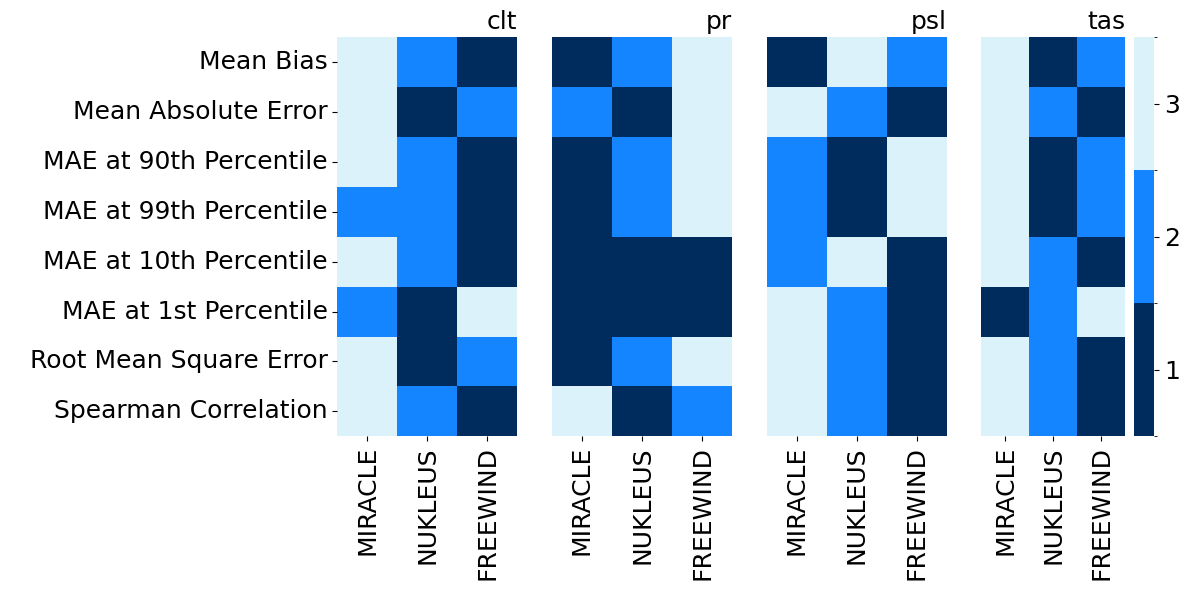

In [9]:
from valenspy.diagnostic_visualizations import plot_metric_ranking
fig, axes = plt.subplots(1,len(variables) , figsize = (12,6)) 
axes = axes.flatten()
n_subs = len(variables)
#label_fontsize = 15
for i,variable in enumerate(variables): 
    ax = axes[i]
    df_metric = d_df_metric_BE28[variable]
    df_metric = df_metric.loc[0:7]
    labels = df_metric["metric"]
    if i == 0: 
        ax = plot_metric_ranking(df_metric, ax=ax, title=variable, plot_colorbar=False, cmap = cmap)
        ax.set_ylabel(' ')
        ax.set_yticklabels(labels = labels, fontsize = 18)
        ax.set_xticklabels(cleaned_experiments, fontsize = 18)

    elif i == n_subs-1: 
        ax = plot_metric_ranking(df_metric, ax=ax, title=variable, plot_colorbar=True, cmap = cmap)
        ax.set_yticks([])
        ax.set_xticklabels(cleaned_experiments, fontsize = 18)
    else:
        ax = plot_metric_ranking(df_metric, ax=ax, title=variable, plot_colorbar=False, cmap = cmap)
        ax.set_yticks([])
        ax.set_xticklabels(cleaned_experiments, fontsize = 18)
    
fig.tight_layout()

In [10]:
ref_dataset = 'ERA5'
variables = ['clt','pr','psl','tas']
model = 'CCLM'

experiments = ["EUR11_CO_TA_GC_TSO","EUR11_CO_TT_GC_TSO","EUR11_CO_TT_EC_TSO","EUR11_NU_TT_GC_TSO","EUR11_NU_TT_EC_TSO"]

d_df_metric_rank = {}
d_df_metric = {}

for variable in variables: 
    print(variable)
    da_obs, dt_mod, gridfile =  load_point_exp_ref(variable, model, ref_dataset, experiments)
    print("starting to calculate metrics")

    df_metric      = calc_metrics(dt_mod, da_obs, save_csv=False)
    df_metric_rank = get_ranks_metrics(df_metric)

    print("df_metric of " + variable + " has been made")

    d_df_metric_rank[variable] =  df_metric_rank
    d_df_metric[variable]      =  df_metric

clt
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/total_cloud_cover/hourly/era5-hourly-europe-total_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clt']
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCT/daily/CLCT_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clt']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/CLCT/daily/CLCT_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clt']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']

In [11]:
d_df_metric_EUR11 = d_df_metric
cleaned_experiments = [exp.replace("EUR11_", "").replace("_TSO", "") for exp in experiments]
print(cleaned_experiments)

['CO_TA_GC', 'CO_TT_GC', 'CO_TT_EC', 'NU_TT_GC', 'NU_TT_EC']


In [15]:
colors=["#002C5D","#005ABC","#1584FF","#52BDEC","#DCF2FB"]
cmap=ListedColormap(colors)

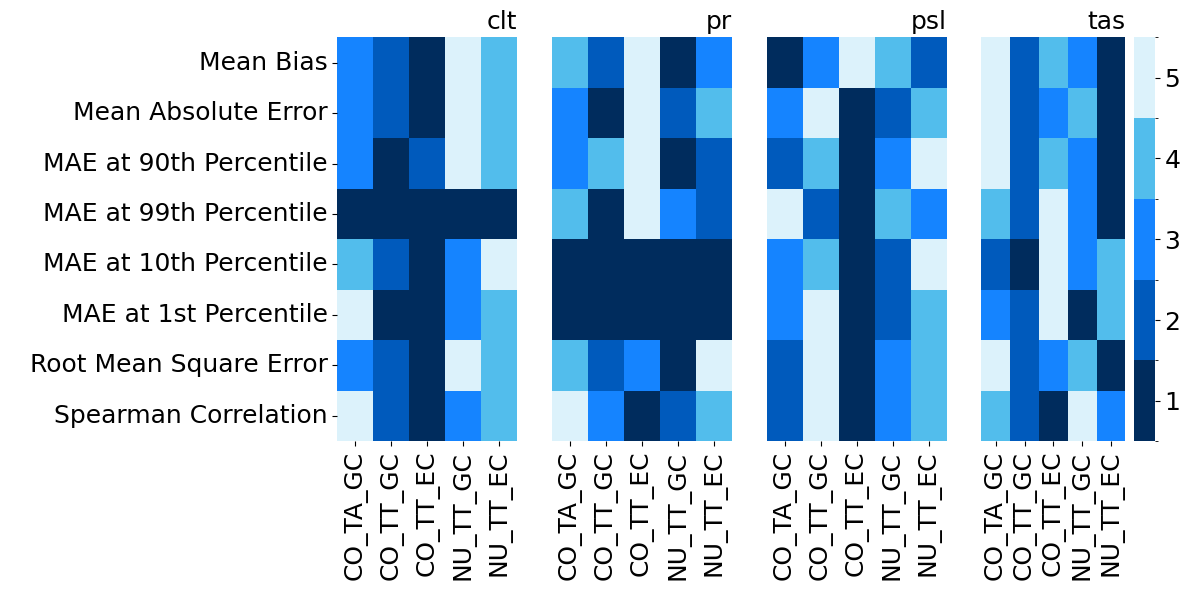

In [16]:
from valenspy.diagnostic_visualizations import plot_metric_ranking
fig, axes = plt.subplots(1,len(variables) , figsize = (12,6)) 
axes = axes.flatten()
n_subs = len(variables)
#label_fontsize = 15
for i,variable in enumerate(variables): 
    ax = axes[i]
    df_metric = d_df_metric_EUR11[variable]
    df_metric = df_metric.loc[0:7]
    labels = df_metric["metric"]
    if i == 0: 
        ax = plot_metric_ranking(df_metric, ax=ax, title=variable, plot_colorbar=False, cmap = cmap)
        ax.set_ylabel(' ')
        ax.set_yticklabels(labels = labels, fontsize = 18)
        ax.set_xticklabels(cleaned_experiments, fontsize = 18)

    elif i == n_subs-1: 
        ax = plot_metric_ranking(df_metric, ax=ax, title=variable, plot_colorbar=True, cmap = cmap)
        ax.set_yticks([])
        ax.set_xticklabels(cleaned_experiments, fontsize = 18)
    else:
        ax = plot_metric_ranking(df_metric, ax=ax, title=variable, plot_colorbar=False, cmap = cmap)
        ax.set_yticks([])
        ax.set_xticklabels(cleaned_experiments, fontsize = 18)
    
fig.tight_layout()